In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from copy import deepcopy



In [2]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super(Cifar10CnnModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(512*2*2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, xb):
        return self.network(xb)


In [3]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle=True):
    loader = DataLoader(dataset, batch_size=n_samples_per_node, shuffle=shuffle)
    data_splitted = []
    for _ in range(nb_nodes):
        images, labels = next(iter(loader))
        data_splitted.append(DataLoader(TensorDataset(images, labels), batch_size=batch_size, shuffle=shuffle))
    return data_splitted
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle=True, shuffle_classes=False):
    assert(nb_nodes > 0 and nb_nodes <= 10)

    classes = torch.arange(10) if not shuffle_classes else torch.randperm(10, generator=torch.Generator().manual_seed(0))
    classes_split = []
    i = 0
    for n in range(nb_nodes, 0, -1):
        inc = int((10 - i) / n)
        classes_split.append(classes[i:i + inc])
        i += inc

    loader = DataLoader(dataset, batch_size=nb_nodes * n_samples_per_node, shuffle=shuffle)
    dataiter = iter(loader)
    images_train_cifar, labels_train_cifar = next(dataiter)

    data_splitted = []
    for i in range(nb_nodes):
        idx = torch.stack([labels_train_cifar == y_ for y_ in classes_split[i]]).any(0)
        data_splitted.append(DataLoader(TensorDataset(images_train_cifar[idx], labels_train_cifar[idx]), batch_size=batch_size, shuffle=shuffle))

    return data_splitted


In [4]:
def get_CIFAR(type, n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    dataset_loaded_train = datasets.CIFAR10(
        root="./data", train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )
    dataset_loaded_test = datasets.CIFAR10(
        root="./data", train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )

    if type == "iid":
        train = iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
        test = iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train = non_iid_split(dataset_loaded_train, n_clients, n_samples_train, batch_size, shuffle)
        test = non_iid_split(dataset_loaded_test, n_clients, n_samples_test, batch_size, shuffle)
    else:
        train = []
        test = []

    return train, test
    return train, test

cifar_iid_train, cifar_iid_test = get_CIFAR("iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)
cifar_non_iid_train, cifar_non_iid_test = get_CIFAR("non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def train_client_model(model, global_model, train_loader, mu, epochs, optimizer, loss_func):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for epoch in range(epochs):
        for data, labels in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, labels)

            # Add proximal term if mu > 0
            if mu > 0:
                prox_term = 0.5 * mu * sum((p_local - p_global).norm(2).pow(2) for p_local, p_global in zip(model.parameters(), global_model.parameters()))
                loss += prox_term

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = (total_correct / total_samples) * 100
    return model, avg_loss, accuracy


In [6]:
def federated_avg(models, weights):
    global_model = deepcopy(models[0])
    global_dict = global_model.state_dict()
    
    for key in global_dict.keys():
        global_dict[key] = torch.stack([weights[i] * models[i].state_dict()[key].float() for i in range(len(models))], 0).sum(0)
        
    global_model.load_state_dict(global_dict)
    return global_model


In [7]:
def federated_learning(train_sets, test_sets, model, rounds, epochs, lr, mu):
    client_weights = [len(train_set.dataset) / sum(len(train_set.dataset) for train_set in train_sets) for train_set in train_sets]
    
    history = {
        'client_losses': [[] for _ in train_sets],
        'client_accuracies': [[] for _ in train_sets],
        'global_losses': [],
        'global_accuracies': []
    }
    
    global_model = model
    
    for round in range(rounds):
        local_models = []
        local_losses = []
        local_accuracies = []

        print(f"\n--- Round {round + 1}/{rounds} ---")
        
        for client_idx, train_set in enumerate(train_sets):
            local_model = deepcopy(global_model)
            optimizer = optim.Adam(local_model.parameters(), lr=lr)
            trained_model, client_loss, client_accuracy = train_client_model(local_model, global_model, train_set, mu, epochs, optimizer, nn.CrossEntropyLoss())
            
            local_models.append(trained_model)
            local_losses.append(client_loss)
            local_accuracies.append(client_accuracy)

            history['client_losses'][client_idx].append(client_loss)
            history['client_accuracies'][client_idx].append(client_accuracy)
        
        global_model = federated_avg(local_models, client_weights)
        
        test_loss, test_accuracy = evaluate(global_model, test_sets[0])
        history['global_losses'].append(test_loss)
        history['global_accuracies'].append(test_accuracy)

        print(f"Global Test Loss: {test_loss:.4f}, Global Test Accuracy: {test_accuracy:.2f}%")
    
    return global_model, history


In [8]:
def evaluate(model, test_loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    loss_func = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, labels in test_loader:
            output = model(data)
            loss = loss_func(output, labels)
            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = (correct / total) * 100
    return avg_loss, accuracy


In [9]:
def plot_metrics(history):
    plt.figure(figsize=(14, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    for i, client_losses in enumerate(history['client_losses']):
        plt.plot(client_losses, label=f'Client {i+1}')
    plt.plot(history['global_losses'], label='Global', linestyle='--')
    plt.title('Loss per Round')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for i, client_accs in enumerate(history['client_accuracies']):
        plt.plot(client_accs, label=f'Client {i+1}')
    plt.plot(history['global_accuracies'], label='Global', linestyle='--')
    plt.title('Accuracy per Round')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.show()



--- Round 1/10 ---
Global Test Loss: 2.2971, Global Test Accuracy: 16.00%

--- Round 2/10 ---
Global Test Loss: 2.2349, Global Test Accuracy: 18.00%

--- Round 3/10 ---
Global Test Loss: 2.1752, Global Test Accuracy: 20.00%

--- Round 4/10 ---
Global Test Loss: 2.3478, Global Test Accuracy: 17.00%

--- Round 5/10 ---
Global Test Loss: 2.3529, Global Test Accuracy: 21.00%

--- Round 6/10 ---
Global Test Loss: 2.6172, Global Test Accuracy: 25.00%

--- Round 7/10 ---
Global Test Loss: 2.9092, Global Test Accuracy: 25.00%

--- Round 8/10 ---
Global Test Loss: 3.9051, Global Test Accuracy: 24.00%

--- Round 9/10 ---
Global Test Loss: 4.4252, Global Test Accuracy: 18.00%

--- Round 10/10 ---
Global Test Loss: 4.5597, Global Test Accuracy: 25.00%


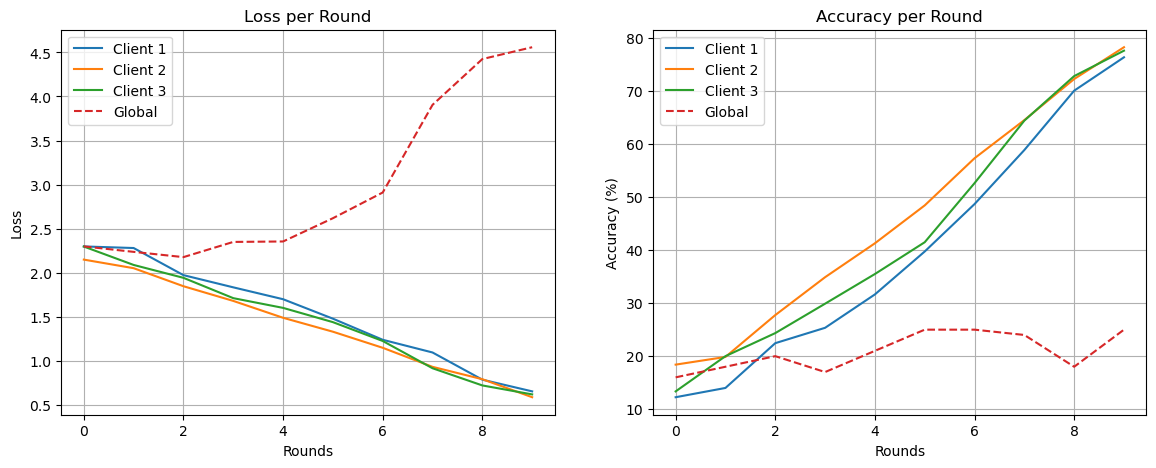

In [23]:
model_0 = Cifar10CnnModel()

# Run federated learning
federated_model, history = federated_learning(
    cifar_iid_train, cifar_iid_test,
    model_0,
    rounds=10,
    epochs=10,  
    lr=0.001,
    mu=0
)

plot_metrics(history)



--- Round 1/10 ---
Global Test Loss: 2.2944, Global Test Accuracy: 14.00%

--- Round 2/10 ---
Global Test Loss: 2.2931, Global Test Accuracy: 14.00%

--- Round 3/10 ---
Global Test Loss: 2.2928, Global Test Accuracy: 14.00%

--- Round 4/10 ---
Global Test Loss: 2.2922, Global Test Accuracy: 14.00%

--- Round 5/10 ---
Global Test Loss: 2.2918, Global Test Accuracy: 14.00%

--- Round 6/10 ---
Global Test Loss: 2.2916, Global Test Accuracy: 14.00%

--- Round 7/10 ---
Global Test Loss: 2.2913, Global Test Accuracy: 14.00%

--- Round 8/10 ---
Global Test Loss: 2.2912, Global Test Accuracy: 14.00%

--- Round 9/10 ---
Global Test Loss: 2.2909, Global Test Accuracy: 14.00%

--- Round 10/10 ---
Global Test Loss: 2.2909, Global Test Accuracy: 14.00%


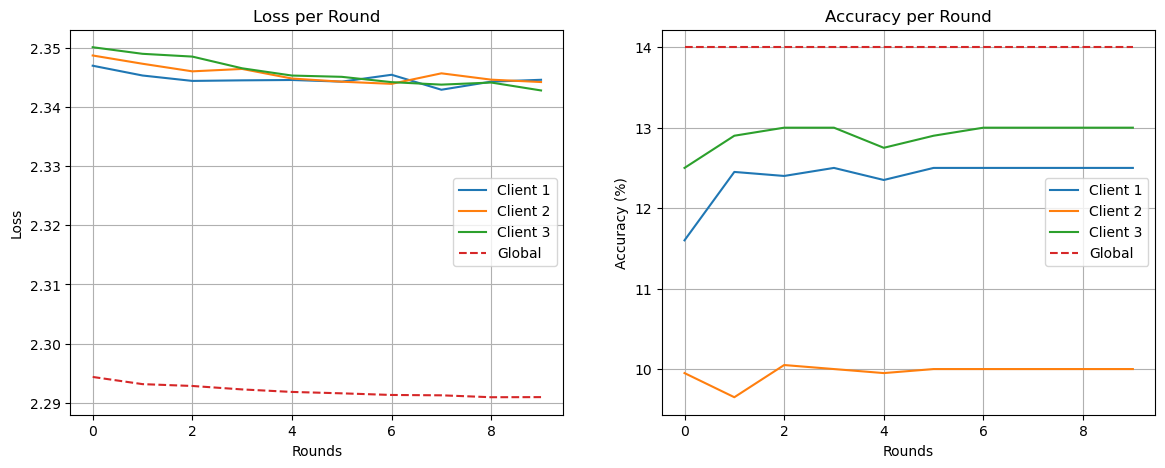

In [11]:
model_0 = Cifar10CnnModel()

# Run federated learning
federated_prox, history_prox = federated_learning(
    cifar_iid_train, cifar_iid_test,
    model_0,
    rounds=10,
    epochs=10,  
    lr=0.001,
    mu = 0.5
)

plot_metrics(history_prox)


--- Round 1/10 ---
Global Test Loss: 2.3160, Global Test Accuracy: 0.00%

--- Round 2/10 ---
Global Test Loss: 2.2518, Global Test Accuracy: 32.56%

--- Round 3/10 ---
Global Test Loss: 2.6171, Global Test Accuracy: 0.00%

--- Round 4/10 ---
Global Test Loss: 2.1367, Global Test Accuracy: 32.56%

--- Round 5/10 ---
Global Test Loss: 2.6027, Global Test Accuracy: 0.00%

--- Round 6/10 ---
Global Test Loss: 2.0723, Global Test Accuracy: 32.56%

--- Round 7/10 ---
Global Test Loss: 2.7448, Global Test Accuracy: 0.00%

--- Round 8/10 ---
Global Test Loss: 2.0560, Global Test Accuracy: 32.56%

--- Round 9/10 ---
Global Test Loss: 2.5960, Global Test Accuracy: 0.00%

--- Round 10/10 ---
Global Test Loss: 1.9886, Global Test Accuracy: 32.56%


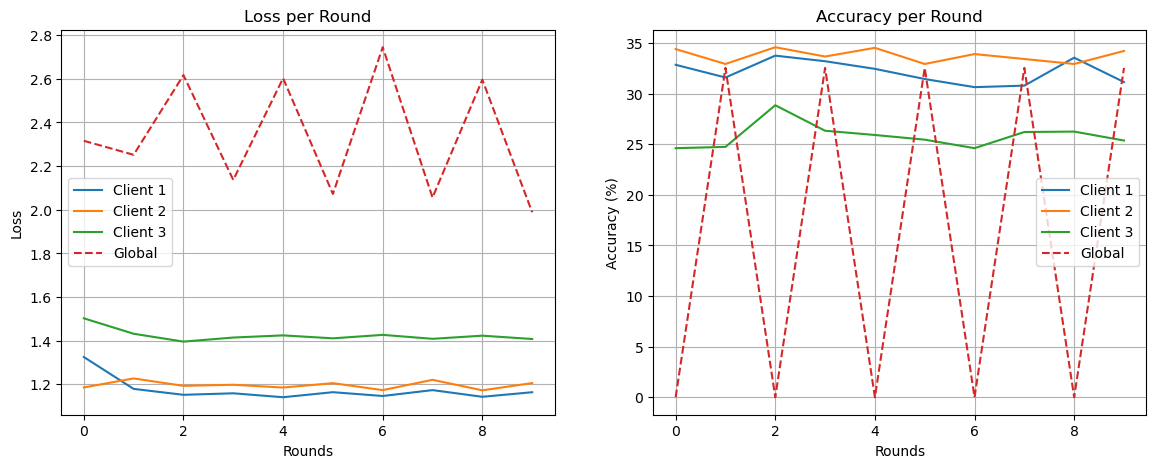

In [12]:
global_model = Cifar10CnnModel()

# Run federated learning
federated_model_non, history_non = federated_learning(
    cifar_non_iid_train, cifar_non_iid_test,
    global_model,
    rounds=10,
    epochs=10,  
    lr=0.001,
    mu=0
)

plot_metrics(history_non)



--- Round 1/10 ---
Global Test Loss: 2.4068, Global Test Accuracy: 0.00%

--- Round 2/10 ---
Global Test Loss: 2.4541, Global Test Accuracy: 0.00%

--- Round 3/10 ---
Global Test Loss: 2.6185, Global Test Accuracy: 0.00%

--- Round 4/10 ---
Global Test Loss: 2.5857, Global Test Accuracy: 0.00%

--- Round 5/10 ---
Global Test Loss: 2.5311, Global Test Accuracy: 0.00%

--- Round 6/10 ---
Global Test Loss: 2.5824, Global Test Accuracy: 0.00%

--- Round 7/10 ---
Global Test Loss: 2.6292, Global Test Accuracy: 0.00%

--- Round 8/10 ---
Global Test Loss: 2.2564, Global Test Accuracy: 0.00%

--- Round 9/10 ---
Global Test Loss: 2.6037, Global Test Accuracy: 0.00%

--- Round 10/10 ---
Global Test Loss: 2.6532, Global Test Accuracy: 0.00%


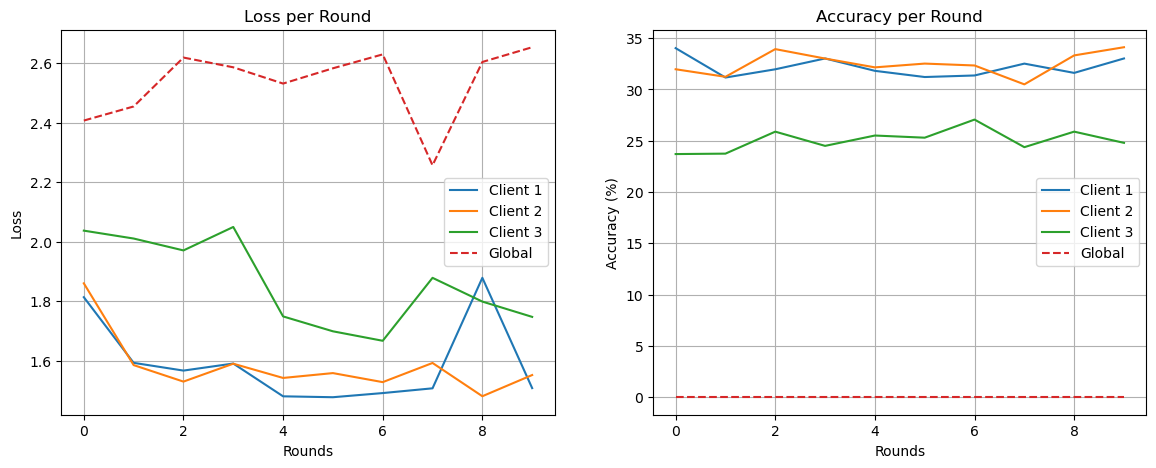

In [13]:
global_model = Cifar10CnnModel()

# Run federated learning
federated_prox_non, history_prox_non = federated_learning(
    cifar_non_iid_train, cifar_non_iid_test,
    global_model,
    rounds=10,
    epochs=10,  
    lr=0.001,
    mu = 0.5
)

plot_metrics(history_prox_non)